<a href="https://colab.research.google.com/github/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/blob/main/07_milestone_project_1_food_vision_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision 101

## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5c634926-163a-5d7a-2d18-d7b5ca41aead)


## Get helper functions

We've created a bunch of helper functions to do small tasks required for our notebooks.

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/refs/heads/main/helper_functions.py

--2025-06-27 20:55:17--  https://raw.githubusercontent.com/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-27 20:55:18 (89.7 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Use TensorFlow Datasets to Download Data

Here is the link of our Food-101 dataset: https://www.tensorflow.org/datasets/catalog/food101

We can also find other Datasets in the same [web home page](https://www.tensorflow.org/datasets/catalog/overview).

In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [4]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS dataset?

True


In [5]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True) # also returns meta data

## Exploring the Food101 data from TensorFlow Datasets

To become one with data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # get one of the train data

In [10]:
# What does one sample of our training data look like?
train_one_sample    # samples are in format (image_tensor, label)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 75,
  Class name (str form): pho
  


In [12]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 48,  51,  30],
        [ 49,  52,  31],
        [ 50,  55,  33],
        ...,
        [ 93, 120,  77],
        [ 87, 112,  70],
        [ 80, 105,  63]],

       [[ 43,  46,  25],
        [ 46,  49,  28],
        [ 49,  54,  32],
        ...,
        [ 95, 122,  77],
        [ 90, 117,  72],
        [ 83, 110,  65]],

       [[ 40,  43,  22],
        [ 45,  48,  27],
        [ 50,  55,  33],
        ...,
        [ 90, 119,  71],
        [ 87, 116,  68],
        [ 84, 113,  65]],

       ...,

       [[ 48,  55,  37],
        [ 48,  55,  37],
        [ 41,  50,  33],
        ...,
        [ 32,  43,  35],
        [ 25,  36,  30],
        [ 21,  32,  26]],

       [[ 42,  47,  27],
        [ 38,  46,  25],
        [ 34,  43,  26],
        ...,
        [ 38,  49,  41],
        [ 33,  44,  38],
        [ 29,  40,  34]],

       [[ 37,  42,  20],
        [ 32,  40,  19],
        [ 31,  38,  20],
        ...,
        [ 33,  44,  3

In [13]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

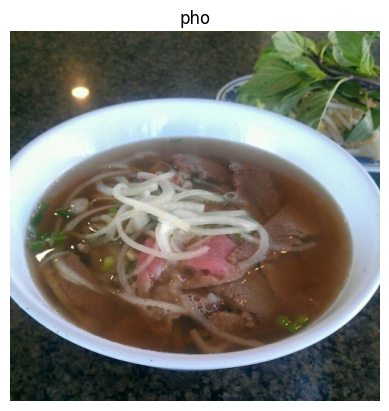

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

 ## Create preprocessing functions for our data

 Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).
 However, not all data (including data from TensorFlow Datasets) comes like this.
 So, in order to get the data ready for a neural network, we'll often have to write preprocessing functions and map it to our data.


 What we know about our data:
 * In `uint8` datatype
 * Comprised of all different size tensors (different sized images)
 * Not scaled (the pixel values are between 0 & 255)


 What we know `models` like:
 * Data in `float32` dtype (or for mixed precision `float16` and `float32`)
 * For batches, TensorFlow likes all of the tensors within a batch to be of the same size
 * Scaled (values between 0 & 1) also called normalized tensors generally perform better.



 With these points in mind, we've got a few things we can tackle with a preprocessing function.


 Since we're going to be using an `EfficientNetBX` pretrained model from `tf.keras.applications`, we don't need to rescale our data (these architectures have rescaling build-in).

 This means our functions needs to:
 1. Reshape our images to all the same size.
 2. Convert the dtype of our images tensors from `uint8` to `float32`.

In [15]:
# Make a functions for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing: \n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 48  51  30]
  [ 49  52  31]
  [ 50  55  33]
  ...
  [ 93 120  77]
  [ 87 112  70]
  [ 80 105  63]]

 [[ 43  46  25]
  [ 46  49  28]
  [ 49  54  32]
  ...
  [ 95 122  77]
  [ 90 117  72]
  [ 83 110  65]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing: 
 [[[ 46.2551    49.2551    28.255102]
  [ 49.954082  54.954082  32.954082]
  [ 42.494896  50.494896  27.494898]
  ...
  [ 97.50995  129.86195   81.4385  ]
  [ 94.02041  122.21427   77.33163 ]
  [ 86.42833  112.71404   68.78547 ]]

 [[ 45.336735  48.336735  27.336735]
  [ 53.714287  58.714287  36.714287]
  [ 40.44388   48.44388   25.443878]
  ...
  [ 92.948906 128.3213    74.52029 ]
  [ 85.48981  117.27552   67.41838 ]
  [ 90.70417  122.48989   72.632744]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch and prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this: https://www.tensorflow.org/guide/data_performance

In [17]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

>Using TensorFlow, we map the preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure to prepare new batches (`prefetch`) whilst the model is looking through (`finding patterns`) the current batch.

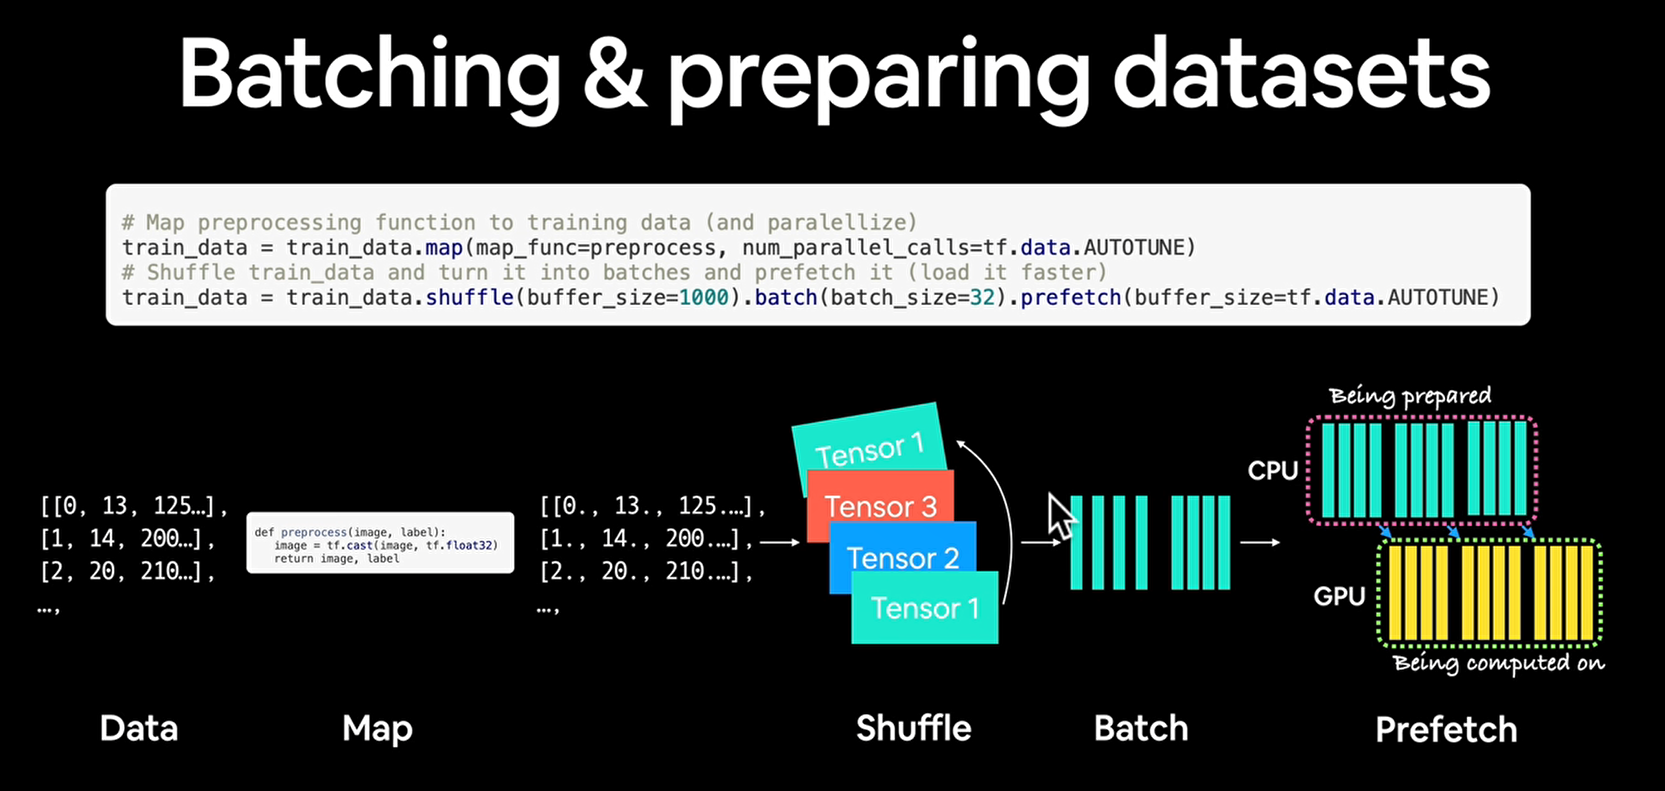

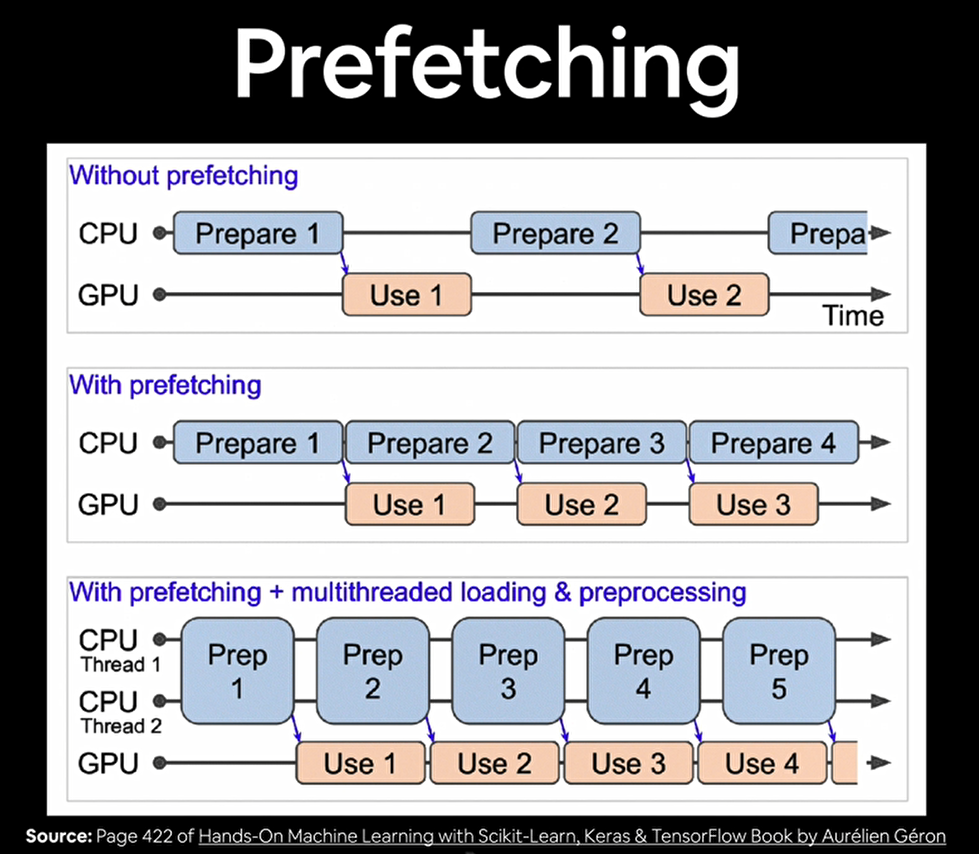

## Creating some modelling callbacks

Different type of callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [19]:
# Create tensorboard callback (import from helper_functions.py).
# The Tensorboard is now officially shutdown.
from helper_functions import create_tensorboard_callback

In [20]:
# Create ModelCheckpoint callback to save a model's progress during training

import os
# Ensure checkpoint directory exists
checkpoint_path = "model_checkpoint/cp.weights.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

# Create EarlyStopping callback to stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # this will monitor the 'val_loss' metric
                                                  patience=2, # Number of epochs with no improvement after which training will be stopped.
                                                  restore_best_weights=True,
                                                  verbose=0) # This callback will stop the training when there is no improvement in the loss for three consecutive epochs.


## Setup mixed precision training

For deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [21]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")  # set global data policy to mixed precision

In [22]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [23]:
import tensorflow as tf
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if the model doesn't we can have a layer like below
# x = preprocessing.Rescaling(1/255.)(x)
x = base_model(inputs, training=False) # make sure layers which should be in inference model only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [24]:
 model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Checking layer dtype policies (are we using mixed precision?)

In [25]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer.
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen).
* `layer.dtype`: the data type a layer stores its variables in.
* `layer.dtype_policy`: the data type policy a layer computes on its variables with.

In [26]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

## Fit the feature extraction model

Our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [27]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint,
                                                                early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250627-205541
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 213s 77ms/step - accuracy: 0.4737 - loss: 2.2910 - val_accuracy: 0.6941 - val_loss: 1.1344
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 163s 68ms/step - accuracy: 0.6666 - loss: 1.2942 - val_accuracy: 0.7180 - val_loss: 1.0333
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 161s 67ms/step - accuracy: 0.7066 - loss: 1.1226 - val_accuracy: 0.7235 - val_loss: 0.9952


In [28]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 69ms/step - accuracy: 0.7219 - loss: 1.0005


[0.9950066804885864, 0.7268118858337402]

## Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:
1. Recreating a new instance of our model called `created_model` by turning our original model creation code into a function called `create_model()`.
2. Compiling our `created_model` with the same loss, optimizer and metrics as the original model (every time we create a new model, we must compile it).
3. Calling the `load_weights()` method on our `created_model` and passing it the path to where our checkpointed weights are stored.
4. Calling `evaluate()` on `created_model` with loaded weights and saving the results.
5. Comparing the `created_model` results to our previous `model` results (these should be the exact same, if not very close).

>Checkpoints are helpful for when we perform an experiment such as fine-tuning our model. In case we fine-tune our feature extraction model and find it doesn't offer any improvements, we can always revert back to the checkpointed version of our model.

In [29]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if our model didn't we could include the next line
  # x = layers.Rescaling(1/255.)(x)
  x = base_model(inputs, training=False) # set the base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class
  # Seperate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  # Attach base_model to model object
  model.base_model = base_model # This line if for if we want to unfreeze base_model's layers for fine-tuning

  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 63ms/step - accuracy: 0.7228 - loss: 0.9982


In [30]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract_2 = created_model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint,
                                                                early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250627-210731
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 205s 75ms/step - accuracy: 0.7256 - loss: 1.0454 - val_accuracy: 0.7304 - val_loss: 0.9790
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 161s 67ms/step - accuracy: 0.7449 - loss: 0.9646 - val_accuracy: 0.7296 - val_loss: 0.9643
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 67ms/step - accuracy: 0.7560 - loss: 0.9159 - val_accuracy: 0.7325 - val_loss: 0.9650


In [31]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

In [32]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]:  # Check only the first 20 layers to save printing space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 False float32 <DTypePolicy "mixed_float16">
rescaling_2 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
rescaling_3 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl

## Save the whole model to file

In [33]:
# Save model locally
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision.keras"
model.save(save_dir)

In [34]:
# Load the model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [35]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]:    # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">

In [36]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 65ms/step - accuracy: 0.7218 - loss: 1.0012


[0.9950064420700073, 0.7268118858337402]

In [37]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if we're instantiated results variables
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

## Preparing our model's layers for fine-tuning

> 🔑**Note:** It's worth remembering a traditional workflow for fine-tuning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with our custom data (feature extraction). And then unfreeze a number of layers or all of the layers in the base model and continue training until the model stops improving.


Here we are going to flow 3 steps to fine-tuning our model.
1. First, we will unfreeze top 20 layers and train our model.
2. Next, we will unfreeze top 50 layers and train our model.
3. At last, we will unfreeze all the layers of our base model and train our model.

After, train all of the model, we will compare all of them each other and trying to find out if any of them start to overfit as training goes on.

### Add `ReduceLROnPlateau` callback

First we want to add another callback `ReduceLROnPlateau` with our existing callbacks `ModelCheckpoint` and `EarlyStopping`.

> **Note:** `ReduceLROnRlateau` callback monitor the validation loss just like the `EarlyStopping` callback. Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`). And to make sure the learning rate doesn't get too low (and potentially result in our model learing nothing), we'll set the minimum learning rate to `1e-7`.

In [38]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

## Fine-tuning with 20 layers unfrozen in the base model

In [39]:
# Unfreeze last 20 layers in the base model

# include these lines if base model is in the local variable, not in the def_function()
# base_model.trainable = False

# for layer in base_model.layers[-20:]:
#   layer.trainable = True

# For our created_model
created_model = create_model()

# Unfreeze last 20 layers
for layer in created_model.base_model.layers[-20:]:
    layer.trainable = True

In [40]:
# Recomile model with lower learning rate: it's typically best practice to lower the learning rate when fine-tuning
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(0.0001),
                      metrics=["accuracy"])

In [41]:
# What layers in the model are trainable?
for layer in created_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense_2 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [42]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(created_model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_layer_2 False float32 <DTypePolicy "mixed_float16">
1 rescaling_4 False float32 <DTypePolicy "mixed_float16">
2 normalization_2 False float32 <DTypePolicy "mixed_float16">
3 rescaling_5 False float32 <DTypePolicy "mixed_float16">
4 stem_conv_pad False float32 <DTypePolicy "mixed_float16">
5 stem_conv False float32 <DTypePolicy "mixed_float16">
6 stem_bn False float32 <DTypePolicy "mixed_float16">
7 stem_activation False float32 <DTypePolicy "mixed_float16">
8 block1a_dwconv False float32 <DTypePolicy "mixed_float16">
9 block1a_bn False float32 <DTypePolicy "mixed_float16">
10 block1a_activation False float32 <DTypePolicy "mixed_float16">
11 block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
12 block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
13 block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
14 block1a_se_expand False float32 <DTypePolicy "mixed_float16">
15 block1a_se_excite False float32 <DTypePolicy "mixed_float16">
16 block1a_project_

### Collect and Print Trainable Layers Only

In [43]:
# List to store trainable layers
trainable_layers = []

# Loop through the base_model layers (inside created_model.layers[1])
for layer_number, layer in enumerate(created_model.layers[1].layers):
    if layer.trainable:
        trainable_layers.append((layer_number, layer.name, layer.dtype, layer.dtype_policy))

# Print the trainable layers
for layer_info in trainable_layers:
    print(layer_info)


print("Total trainable layers: ", len(trainable_layers))

(218, 'block6d_project_conv', 'float32', <DTypePolicy "mixed_float16">)
(219, 'block6d_project_bn', 'float32', <DTypePolicy "mixed_float16">)
(220, 'block6d_drop', 'float32', <DTypePolicy "mixed_float16">)
(221, 'block6d_add', 'float32', <DTypePolicy "mixed_float16">)
(222, 'block7a_expand_conv', 'float32', <DTypePolicy "mixed_float16">)
(223, 'block7a_expand_bn', 'float32', <DTypePolicy "mixed_float16">)
(224, 'block7a_expand_activation', 'float32', <DTypePolicy "mixed_float16">)
(225, 'block7a_dwconv', 'float32', <DTypePolicy "mixed_float16">)
(226, 'block7a_bn', 'float32', <DTypePolicy "mixed_float16">)
(227, 'block7a_activation', 'float32', <DTypePolicy "mixed_float16">)
(228, 'block7a_se_squeeze', 'float32', <DTypePolicy "mixed_float16">)
(229, 'block7a_se_reshape', 'float32', <DTypePolicy "mixed_float16">)
(230, 'block7a_se_reduce', 'float32', <DTypePolicy "mixed_float16">)
(231, 'block7a_se_expand', 'float32', <DTypePolicy "mixed_float16">)
(232, 'block7a_se_excite', 'float32', 

In [44]:
created_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_7 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 1,480,341 (5.65 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [45]:
# Start to fine-tune (20 layers unfrozen in the base model)
history_20_layers_fine_tune = created_model.fit(train_data,
                                                epochs=100, # fine-tune for a maximum of 100 epochs
                                                steps_per_epoch=len(train_data),
                                                validation_data=test_data,
                                                validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                callbacks=[model_checkpoint, # save only the best model during training
                                                           early_stopping, # stop model after X epochs of no improvements
                                                           reduce_lr]) # reduce the learning rate after X epochs of no improvements

Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 216s 77ms/step - accuracy: 0.3695 - loss: 2.9228 - val_accuracy: 0.7050 - val_loss: 1.1022 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 196s 82ms/step - accuracy: 0.6569 - loss: 1.3425 - val_accuracy: 0.7481 - val_loss: 0.9105 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 203s 83ms/step - accuracy: 0.7079 - loss: 1.1246 - val_accuracy: 0.7654 - val_loss: 0.8357 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 166s 68ms/step - accuracy: 0.7404 - loss: 0.9832 - val_accuracy: 0.7752 - val_loss: 0.7940 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 68ms/step - accuracy: 0.7701 - loss: 0.8667 - val_accuracy: 0.7900 - val_loss: 0.7593 - learning_rate: 1.0000e-04
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 85ms/step - accuracy: 0.7915 - loss: 0.7720 - val_accuracy: 0.7929 - val_loss: 0.7422 - learning_rate: 1.0000e-04
Epoch 7/100
2368/2368 ━━━━━━

In [46]:
# Evaluate on the whole test dataset
created_model_20_layers_fine_tune_results = created_model.evaluate(test_data)
created_model_20_layers_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.7929 - loss: 0.7396


[0.7394580841064453, 0.7940198183059692]

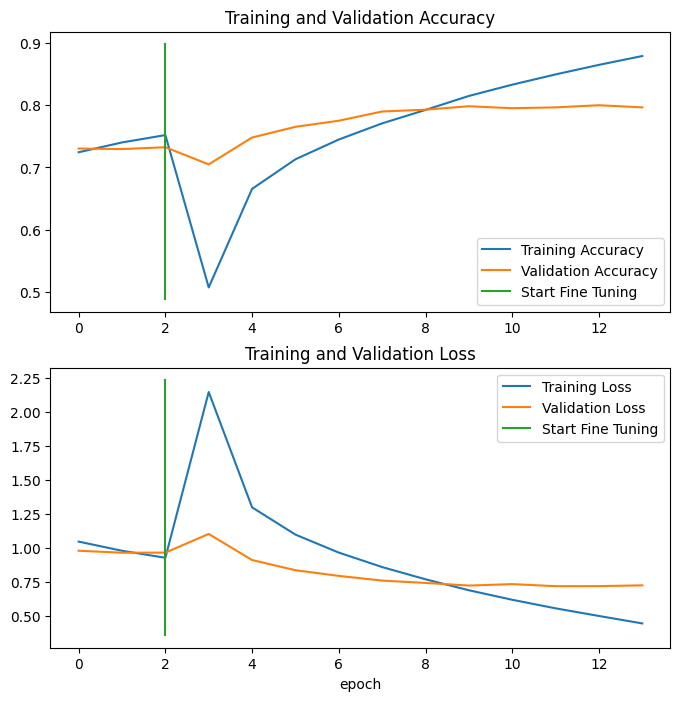

In [47]:
# Compare the histories of feature extraction model with fine-funing model
compare_historys(original_history=history_101_food_classes_feature_extract_2,
                 new_history=history_20_layers_fine_tune,
                 initial_epochs=3)

### Saving and loading our model

In [48]:
# Save our fine-tuning model
created_model.save("/content/drive/MyDrive/Colab_Notebooks/created_model_20_layers_fine_tune.keras")

In [49]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/created_model_20_layers_fine_tune.keras")

In [50]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 65ms/step - accuracy: 0.7931 - loss: 0.7380


[0.7394582033157349, 0.7940198183059692]

In [51]:
# The results from our loaded model (above) should be very similar to the results below
created_model_20_layers_fine_tune_results

[0.7394580841064453, 0.7940198183059692]

### Making predictions with our trained model

In [52]:
# Make predictions with model
preds_probs = created_model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 73ms/step


In [53]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [54]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[1.9474583e-05, 1.8896675e-04, 3.7598881e-04, ..., 8.1340850e-06,
        1.7085851e-05, 6.4597748e-06],
       [2.5371750e-04, 2.5843052e-05, 3.0213589e-05, ..., 3.2428969e-02,
        2.4890804e-03, 8.0697988e-05],
       [7.7408204e-06, 1.0892940e-03, 9.3189929e-06, ..., 9.9812914e-04,
        5.2787805e-06, 1.5010746e-04],
       ...,
       [3.2725411e-06, 1.8919219e-06, 2.1648668e-06, ..., 2.1345143e-09,
        8.1676831e-08, 6.4874263e-07],
       [2.8439283e-06, 7.8370158e-06, 2.9142145e-06, ..., 2.3098405e-06,
        2.5044869e-07, 9.6068025e-06],
       [2.5753893e-06, 3.8970211e-05, 3.9269994e-06, ..., 8.9539462e-06,
        9.2771015e-04, 2.0896912e-06]], dtype=float32)

In [55]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.94745826e-05, 1.88966747e-04, 3.75988806e-04, 3.23964370e-04,
        3.27414346e-05, 1.92628487e-03, 2.13020780e-06, 2.75295824e-02,
        1.50782125e-05, 5.11662278e-04, 1.67553826e-05, 4.47722785e-02,
        1.04852506e-05, 4.56348898e-05, 4.10530425e-04, 2.06901350e-05,
        1.90234532e-05, 4.40518397e-06, 2.35898118e-03, 1.80313335e-04,
        1.28970778e-05, 5.25176029e-06, 1.34633274e-05, 7.05217303e-07,
        6.81058591e-05, 9.21712581e-06, 2.71741796e-04, 3.29933027e-06,
        1.34108386e-05, 1.54961945e-05, 2.67750238e-05, 3.11811382e-05,
        5.48933516e-04, 5.90559430e-05, 2.91821227e-04, 4.43239434e-04,
        4.01156431e-05, 6.63983737e-05, 3.38467980e-05, 7.26400467e-05,
        4.17136689e-05, 2.99866042e-05, 2.81698067e-05, 1.90198433e-03,
        6.70900226e-01, 2.09371487e-04, 6.73388888e-04, 6.47530379e-03,
        2.12461018e-04, 1.26971272e-05, 9.37994337e-04, 2.75482540e-04,
        5.30488149e-04, 1.21156827e-05, 4.18769341e-05, 4.506593

In [56]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.94745826e-05 1.88966747e-04 3.75988806e-04 3.23964370e-04
 3.27414346e-05 1.92628487e-03 2.13020780e-06 2.75295824e-02
 1.50782125e-05 5.11662278e-04 1.67553826e-05 4.47722785e-02
 1.04852506e-05 4.56348898e-05 4.10530425e-04 2.06901350e-05
 1.90234532e-05 4.40518397e-06 2.35898118e-03 1.80313335e-04
 1.28970778e-05 5.25176029e-06 1.34633274e-05 7.05217303e-07
 6.81058591e-05 9.21712581e-06 2.71741796e-04 3.29933027e-06
 1.34108386e-05 1.54961945e-05 2.67750238e-05 3.11811382e-05
 5.48933516e-04 5.90559430e-05 2.91821227e-04 4.43239434e-04
 4.01156431e-05 6.63983737e-05 3.38467980e-05 7.26400467e-05
 4.17136689e-05 2.99866042e-05 2.81698067e-05 1.90198433e-03
 6.70900226e-01 2.09371487e-04 6.73388888e-04 6.47530379e-03
 2.12461018e-04 1.26971272e-05 9.37994337e-04 2.75482540e-04
 5.30488149e-04 1.21156827e-05 4.18769341e-05 4.50659310e-04
 1.81932258e-03 2.34256062e-04 3.71734386e-

In [75]:
# test_data.class_names
# the above line code is not useful for TensorFlow Datasets (TFDS). so we will use bellow code
class_names = ds_info.features["label"].names
class_names[32]

'dumplings'

In [59]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([44, 15, 49, 12,  7, 33, 52, 69, 54, 88])

In [60]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [61]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())   # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

### Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [62]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.007920792079207921

In [63]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(preds_probs[1], sklearn_accuracy)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

### Let's get visual: making a confusion matrix

In [64]:
# We can import confusion matrix from helper_functions
from helper_functions import make_confusion_matrix

In [68]:
# Get a list of class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [73]:
# We need to make some changes to our make_confusion_matrix_function to ensure the x-labels print vertically
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """
  Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_pred and y_true.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels  = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Change (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
               horizontalalignment="center",
               color="white" if cm[i, j] > threshold else "black",
               size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [74]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

/tmp/ipython-input-73-2086871507.py:35: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it


### Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02     25250
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The numbers above give a great class-by-class evaluation of our model's predictions but with so mnay classes, they're quite hard to understand.

Let's create a visualization to get a better understanding.

In [77]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'0': {'precision': 1.0,
  'recall': 0.007920792079207921,
  'f1-score': 0.015717092337917484,
  'support': 25250.0},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '11': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '12': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support

Let's plot all of our classes F1-scores.

In [78]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.015717092337917484,
 'baby_back_ribs': 0.0,
 'baklava': 0.0,
 'beef_carpaccio': 0.0,
 'beef_tartare': 0.0,
 'beet_salad': 0.0,
 'beignets': 0.0,
 'bibimbap': 0.0,
 'bread_pudding': 0.0,
 'breakfast_burrito': 0.0,
 'bruschetta': 0.0,
 'caesar_salad': 0.0,
 'cannoli': 0.0,
 'caprese_salad': 0.0,
 'carrot_cake': 0.0,
 'ceviche': 0.0,
 'cheesecake': 0.0,
 'cheese_plate': 0.0,
 'chicken_curry': 0.0,
 'chicken_quesadilla': 0.0,
 'chicken_wings': 0.0,
 'chocolate_cake': 0.0,
 'chocolate_mousse': 0.0,
 'churros': 0.0,
 'clam_chowder': 0.0,
 'club_sandwich': 0.0,
 'crab_cakes': 0.0,
 'creme_brulee': 0.0,
 'croque_madame': 0.0,
 'cup_cakes': 0.0,
 'deviled_eggs': 0.0,
 'donuts': 0.0,
 'dumplings': 0.0,
 'edamame': 0.0,
 'eggs_benedict': 0.0,
 'escargots': 0.0,
 'falafel': 0.0,
 'filet_mignon': 0.0,
 'fish_and_chips': 0.0,
 'foie_gras': 0.0,
 'french_fries': 0.0,
 'french_onion_soup': 0.0,
 'french_toast': 0.0,
 'fried_calamari': 0.0,
 'fried_rice': 0.0,
 'frozen_yogurt': 0.0,
 'g

In [79]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)


In [80]:
f1_scores

class_names  f1-score
0         apple_pie  0.015717
1    baby_back_ribs  0.000000
2           baklava  0.000000
3    beef_carpaccio  0.000000
4      beef_tartare  0.000000
..              ...       ...
96            tacos  0.000000
97         takoyaki  0.000000
98         tiramisu  0.000000
99     tuna_tartare  0.000000
100         waffles  0.000000

[101 rows x 2 columns]

In [81]:
print(f1_scores[:10])
print("=================================")
print(f1_scores[-10:])

         class_names  f1-score
0          apple_pie  0.015717
1     baby_back_ribs  0.000000
2            baklava  0.000000
3     beef_carpaccio  0.000000
4       beef_tartare  0.000000
5         beet_salad  0.000000
6           beignets  0.000000
7           bibimbap  0.000000
8      bread_pudding  0.000000
9  breakfast_burrito  0.000000
              class_names  f1-score
91    spaghetti_carbonara       0.0
92           spring_rolls       0.0
93                  steak       0.0
94   strawberry_shortcake       0.0
95                  sushi       0.0
96                  tacos       0.0
97               takoyaki       0.0
98               tiramisu       0.0
99           tuna_tartare       0.0
100               waffles       0.0


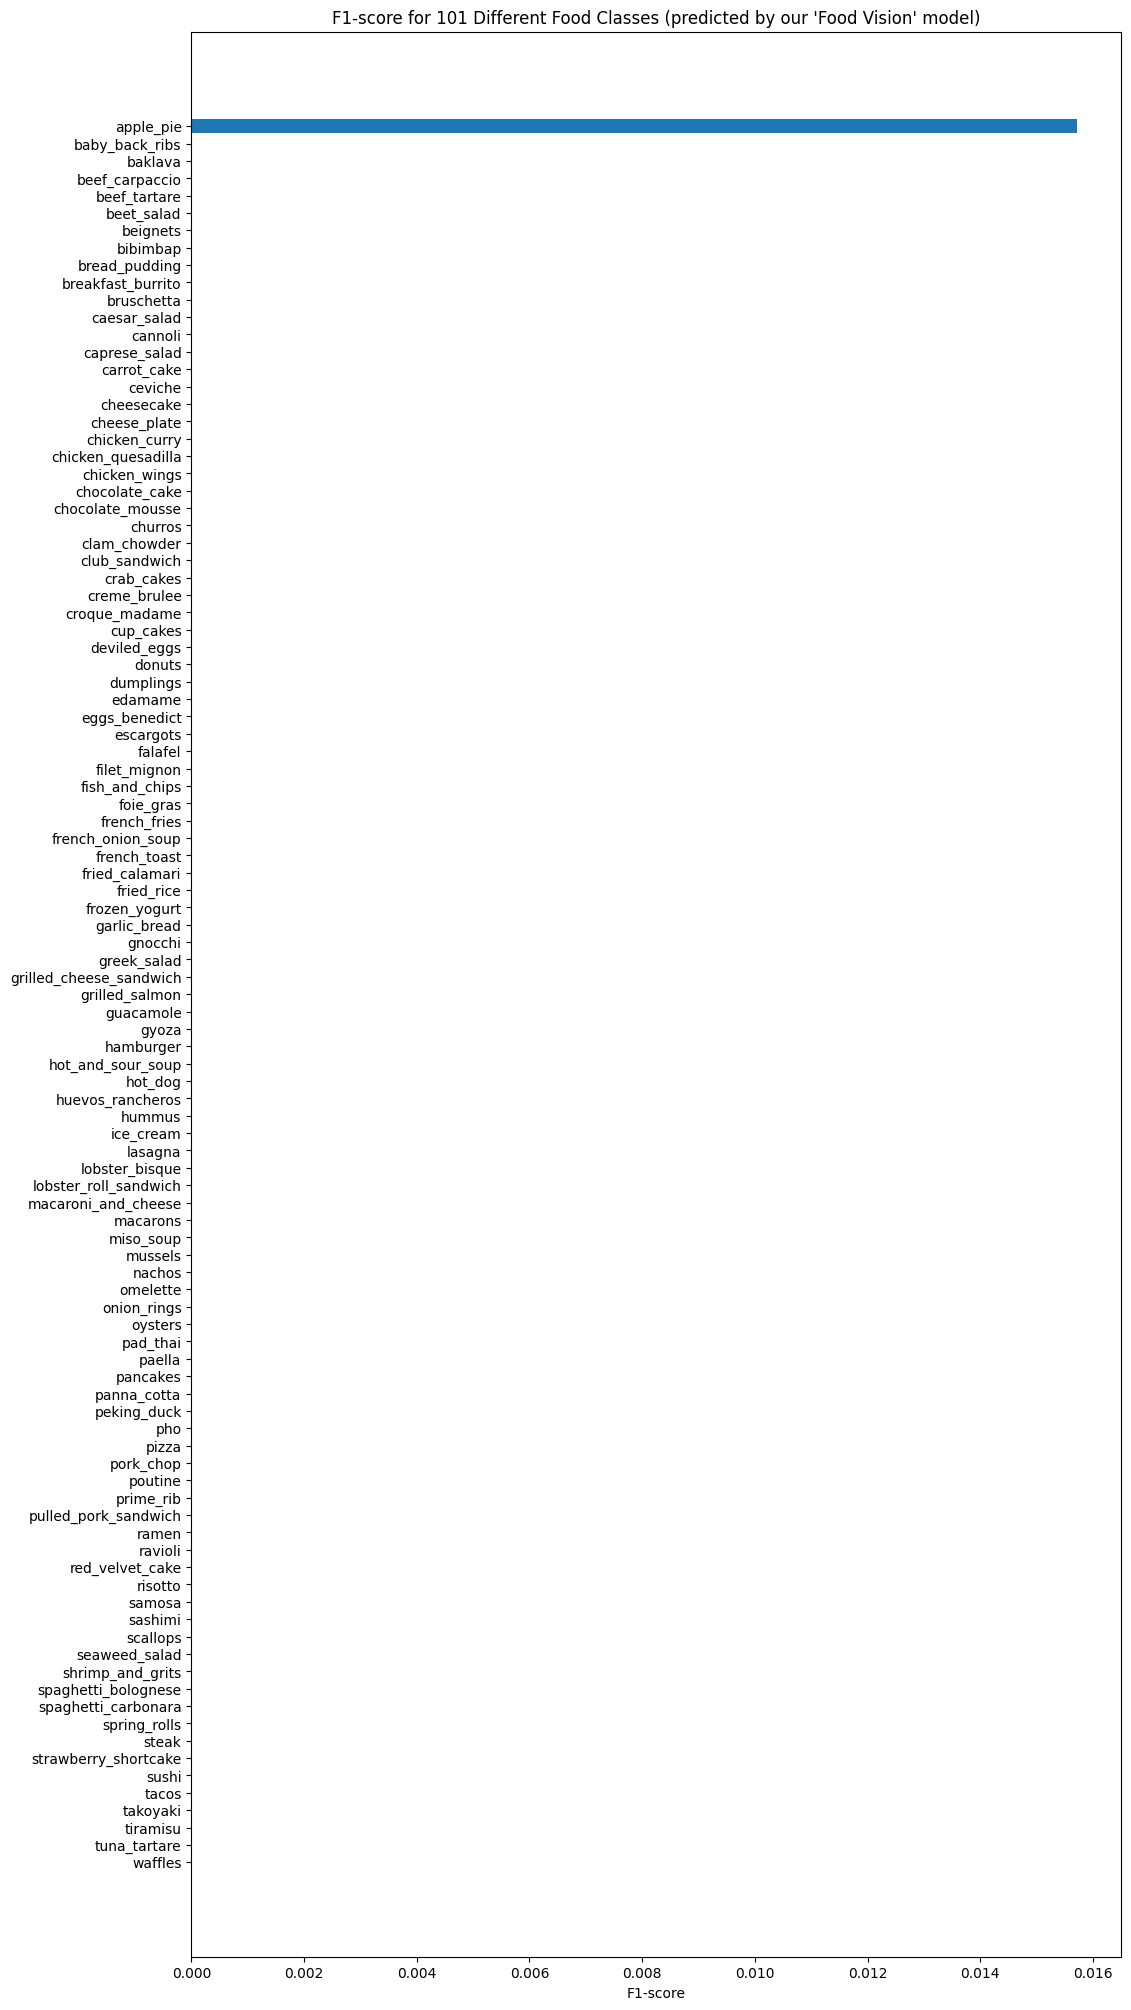

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 Different Food Classes (predicted by our 'Food Vision' model)")
ax.invert_yaxis(); # reverse the order of our plot

### Visualizing predictions on custom images
To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [83]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow



Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:

1. Load a few random images from the test dataset.
2. Make predictions on the loaded images.
3. Plot the original image(s) along with model's predictions, prediction probability and truth label.

In [84]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [85]:
# Make a preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image(s) from a random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + filename

  # Load the image and make predictions
  img = load_and_pred_image(filepath, scale=False)
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = created_model.predict(img_expanded)
  # Get prediction class name
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list


  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

NameError: name 'test_dir' is not defined

<Figure size 1700x1000 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

# Get class names from ds_info
class_names = ds_info.features["label"].names

# Take 3 random samples from test_data
samples = list(test_data.shuffle(1000).take(3))  # tf.data.Dataset → iterable

plt.figure(figsize=(17, 10))

for i, (img, label) in enumerate(samples):
    img_expanded = tf.expand_dims(img, axis=0)  # add batch dimension

    # Predict
    pred_prob = created_model.predict(img_expanded)
    pred_class = class_names[tf.argmax(pred_prob[0])]
    true_class = class_names[label.numpy()]

    # Plot
    plt.subplot(1, 3, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis(False)
    title_color = "g" if pred_class == true_class else "r"
    plt.title(f"Actual: {true_class}\nPred: {pred_class}\nProb: {np.max(pred_prob):.2f}", color=title_color)


NameError: name 'created_model' is not defined

<Figure size 1700x1000 with 0 Axes>

### Finding the most wrong predictions
To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file paths in the test dataset using `list_files()` method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),  # get the maximum prediction probability value
                        "y_ture_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 0  # can change start_index as we want to where we want to start
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  # print(row)
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)